In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster import hierarchy
import os
import json
import shutil

In [43]:
# Инициализируем функции для определния момента остановки
def apply_trend_coefficient(y0 ,y1, y2, y3, trend, i):
    y0 += (i-3)*trend
    y1 -= y0 - (i-2)*trend;
    y2 -= y0 - (i-1)*trend;
    y3 -= y0 - (i)*trend;
    return [y1, y2, y3]

def exponent_criterie(y0 ,y1, y2, y3, trend, i):
    y1, y2, y3 = apply_trend_coefficient(y0 ,y1, y2, y3, trend, i)
              
    return 0.06563 * (y1**2) - 0.04925 * (y2**2) + y1*(0.1186 * y2 - 0.2594 * y3) - 0.3451 * y2 * y3 + 0.2265 * (y3**2)

def porabol_criterie(y0 ,y1, y2, y3, trend, i):
    y1, y2, y3 = apply_trend_coefficient(y0 ,y1, y2, y3, trend, i)
    return 19*y1**2 + 11*y2**2 + 41*y3**2 + 12 * y1 * y2 - 64 * y1 * y3 - 46 * y2 * y3

def check_criteria(y0 ,y1, y2, y3, trend, i, criteria):
    match criteria:
        case 'porabol_4':
            return porabol_criterie(y0 ,y1, y2, y3, trend, i)
        case 'exponent_4':
            return exponent_criterie(y0 ,y1, y2, y3, trend, i)

In [59]:
def save_clusters(clusters):
  for index in np.unique(clusters):
     cluster_map[f'{index}'] = {}
     cluster_map[f'{index}']['length'] = 0
     cluster_map[f'{index}']['points'] = []
  for point in range(len(clusters)):
      cluster_map[f'{clusters[point]}']['points'].append(point)
      cluster_map[f'{clusters[point]}']['length'] += 1
  cluster_map[f'{-1}'] = {}
  cluster_map[f'{-1}']['points'] = [] 
  cluster_map[f'{-1}']['length'] = 0 
  for index in np.unique(clusters):
      if(cluster_map[f'{index}']['length'] == 1):
          cluster_map[f'{-1}']['points'].append(cluster_map[f'{index}']['points'][0])  
          cluster_map[f'{-1}']['length'] += 1 
          del cluster_map[f'{index}']
  with open(f'Clasters/{method}/cls{i}.json', "w", encoding="utf-8") as fl:
      json.dump(cluster_map, fl)

In [63]:
# Настройки
file_name = 'interferon_s.xlsx'
show_images = True

#methods = ['average', 'complete', 'ward', 'centroid']
methods = ['ward']
criteria = 'porabol_4'
trend_step = 100

above_threshold_color_dendro = '#EFE7E6'
no_labels_dendro = True
image_width = 18
image_height = 12

In [14]:
# Считываем и предобрабатываем данные
ds = pd.read_excel(file_name)
ds = ds.dropna(axis = 1)

first_col = ds.iloc[:, 0].tolist()
data = {}
for a,elem in enumerate(first_col):
    data[elem] = ds.iloc[a, 1:].tolist() 

df = pd.DataFrame(data)

In [15]:
df

,IFI27L1,IFI44L,IFIT1,RSAD2,SIGLEC1,STAT1,CXCL9,CXCL10,HLA-DRA,GZMA,PRF1,IDO1,CXCL11,CCR5,IFNG
0,0.107023,-5.174494,-3.234035,-5.312329,-0.585726,-1.467854,-1.812334,-3.088429,-3.229872,-2.364096,-1.735602,-2.487832,-4.489293,-1.861979,-1.53628
1,2.338623,-3.954694,-4.464435,-4.496329,4.112874,0.105946,3.541666,-0.220029,1.893528,2.418004,5.107198,1.201368,-1.153093,1.910621,1.69102
2,0.200823,-0.386494,-2.312735,-1.299829,0.417374,0.810946,2.677966,1.768371,-0.479572,0.201304,0.462298,-0.738932,0.971307,-0.093879,1.59482
3,-0.176177,-0.937094,-1.694235,-1.239829,-0.087526,1.206946,3.281866,2.740071,1.976628,2.057204,0.180598,-0.582332,1.784707,2.592721,2.03232
4,-0.082777,-2.731894,-2.595635,-2.812129,-0.269926,-0.289754,0.039566,-0.214629,-1.180572,-1.640396,-1.822102,-4.127432,-0.158593,-0.656779,-1.31938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0.915123,-1.518394,-1.701335,-1.142329,0.098074,0.187646,3.157566,1.241671,0.130028,-0.600196,0.283098,1.159168,1.447507,-0.260579,0.07232
470,0.808523,0.540706,0.201165,-0.467629,2.354974,0.667246,5.298166,3.009271,1.174828,4.079904,3.389098,3.918368,2.681207,2.231221,4.08202
471,0.383323,0.985006,0.340365,0.738671,1.715574,2.262946,4.872766,4.177471,1.573528,2.092404,2.482098,1.862268,3.809407,1.445121,3.51082
472,1.329823,-3.178794,-2.573235,-3.396629,-1.626126,-1.723454,-3.386634,-4.819129,-3.706372,-5.440196,-3.048802,-4.066832,-4.358193,-3.924279,-2.05578


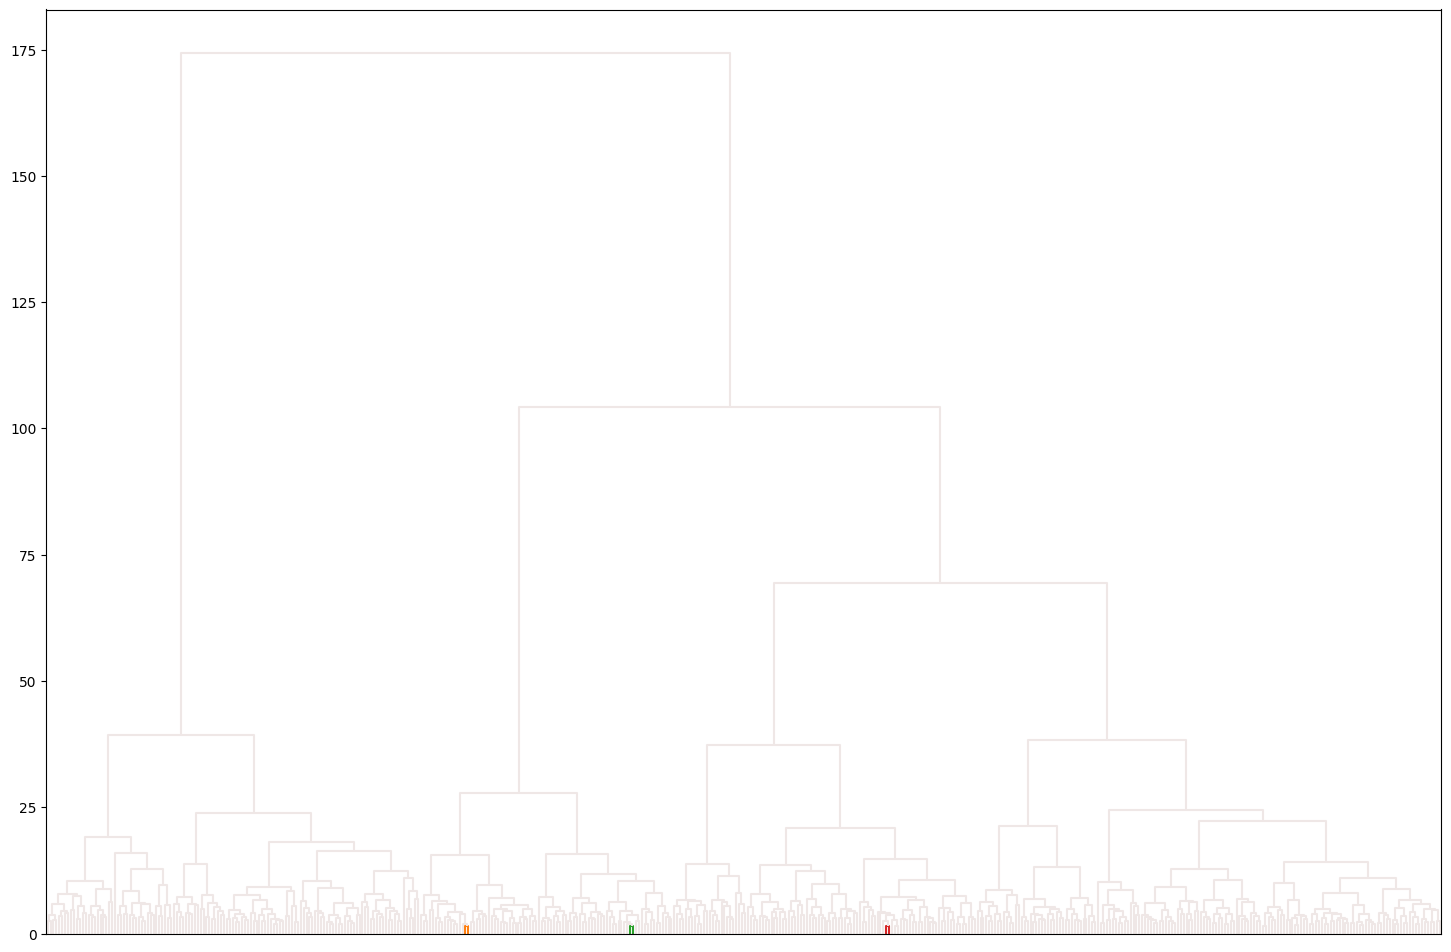

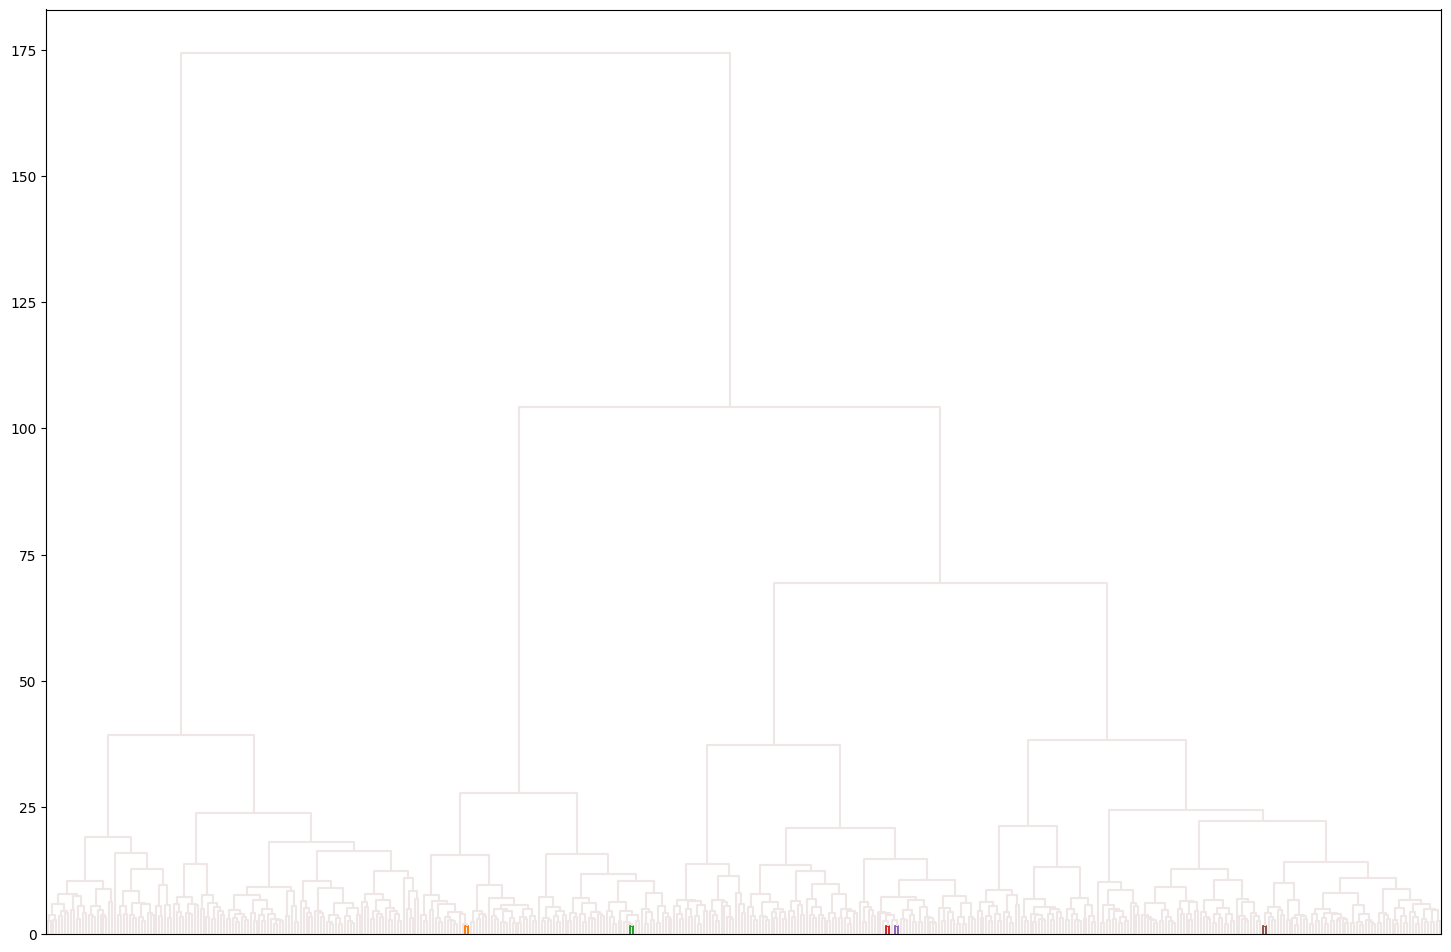

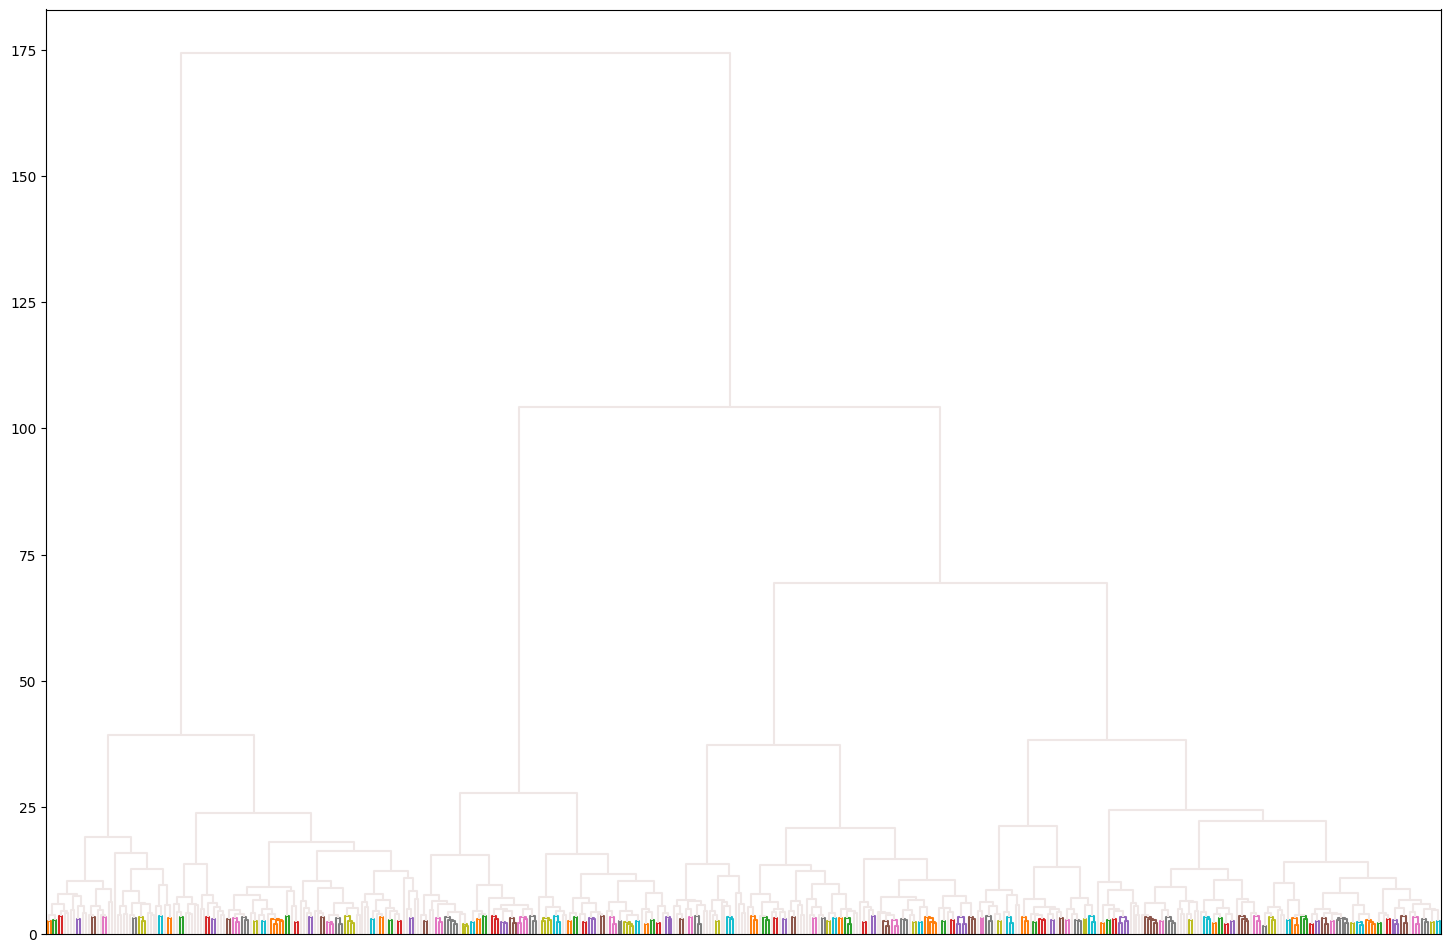

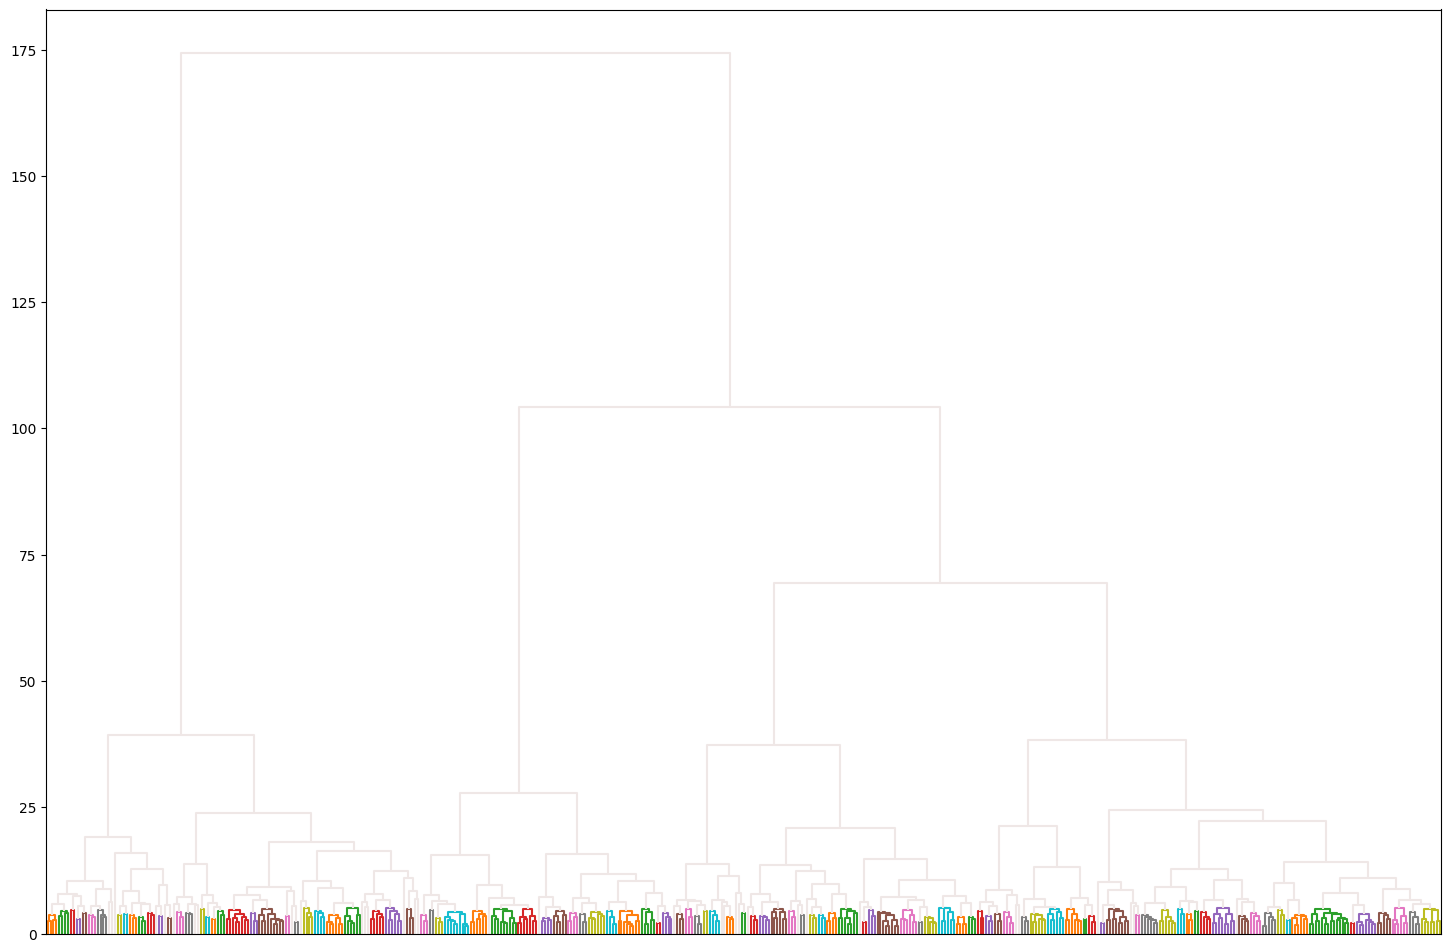

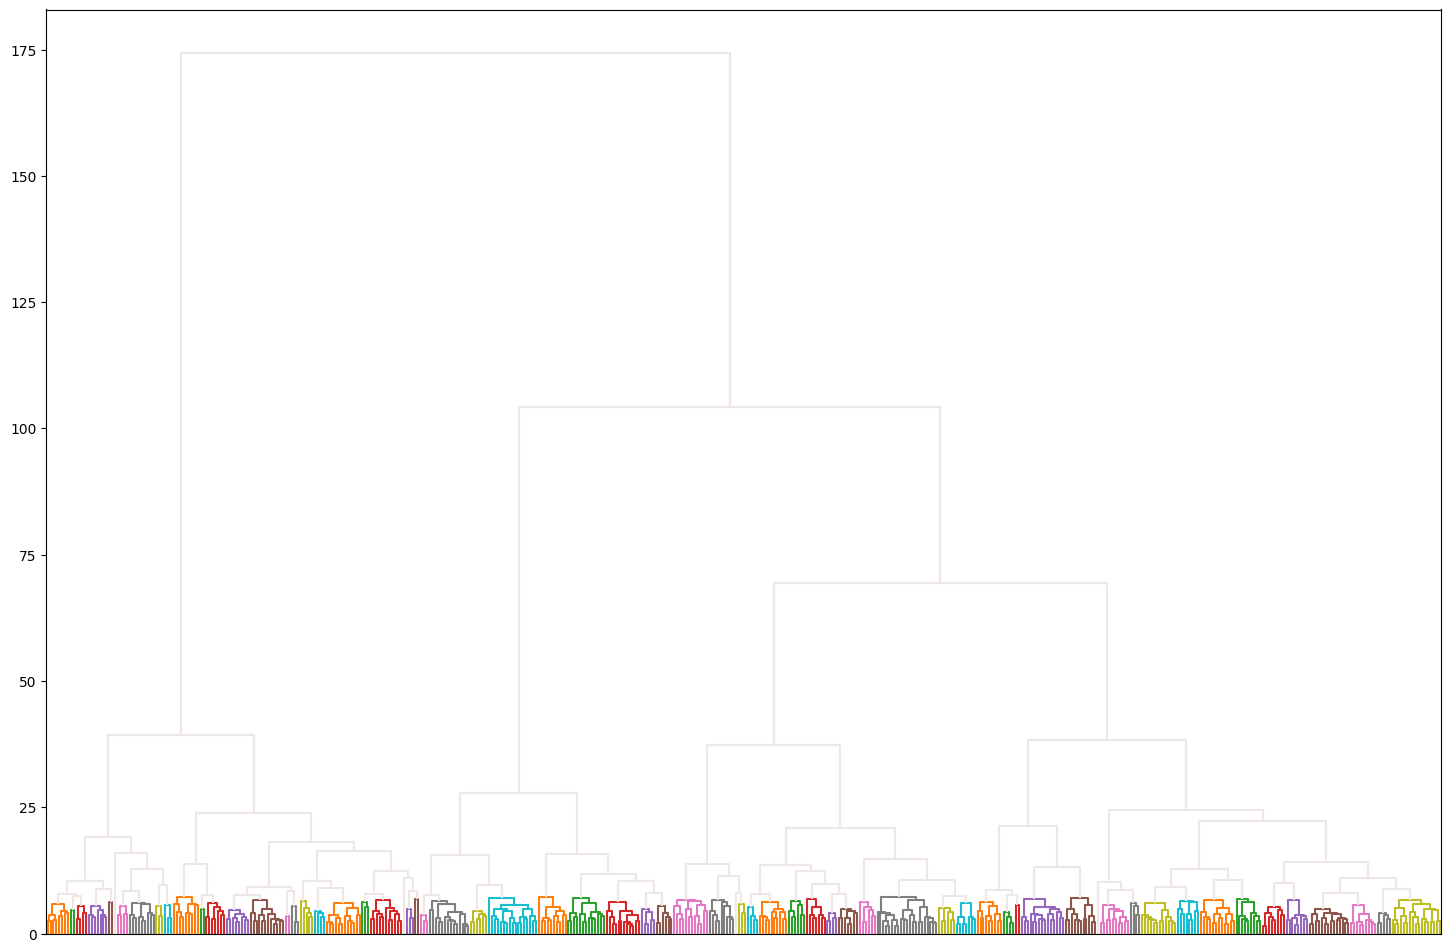

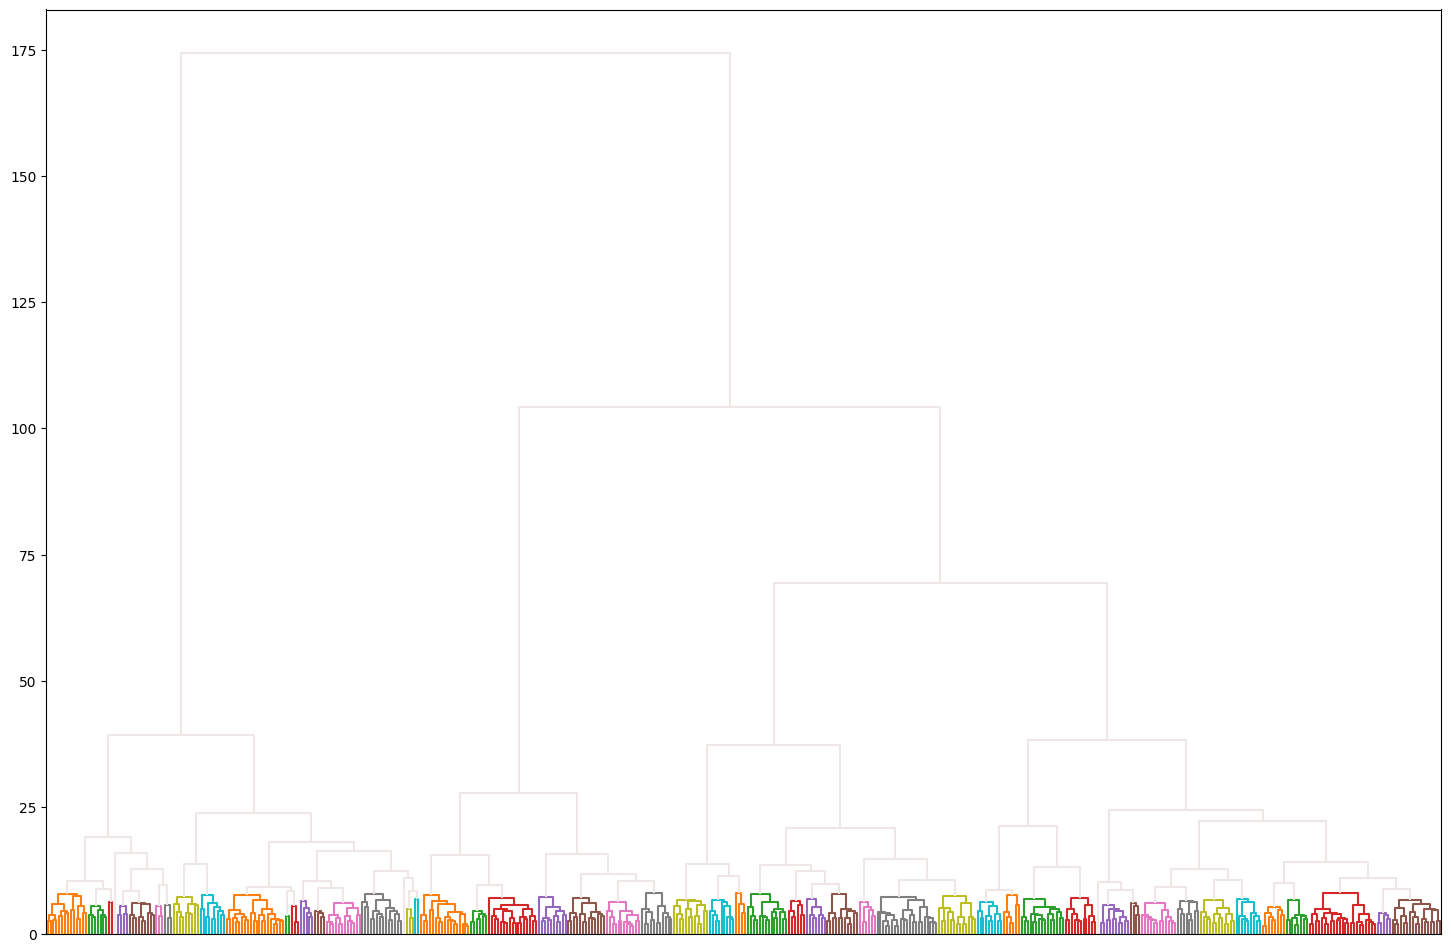

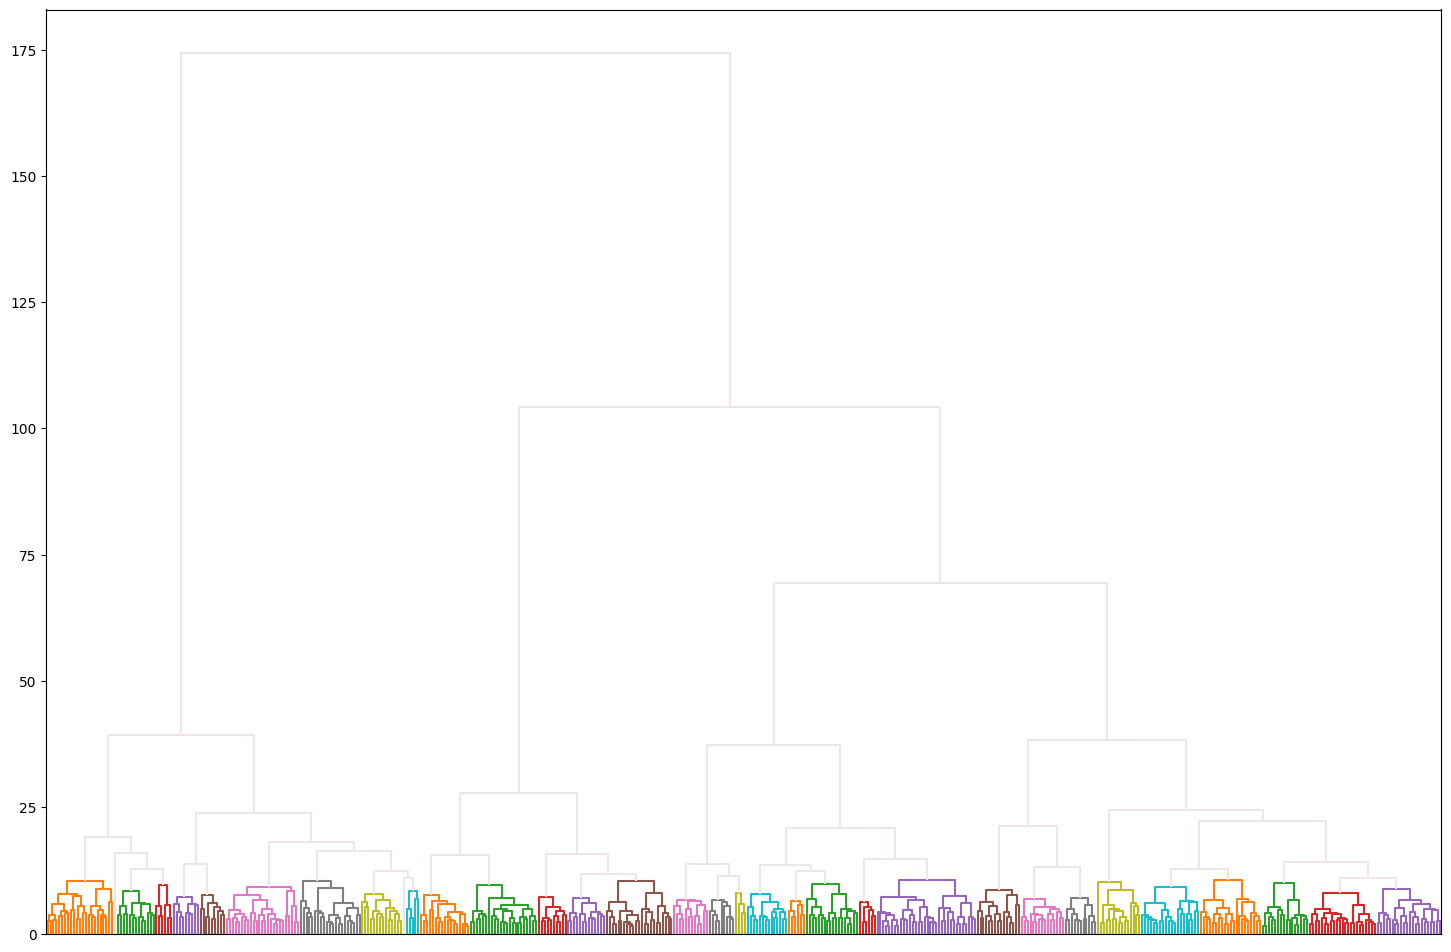

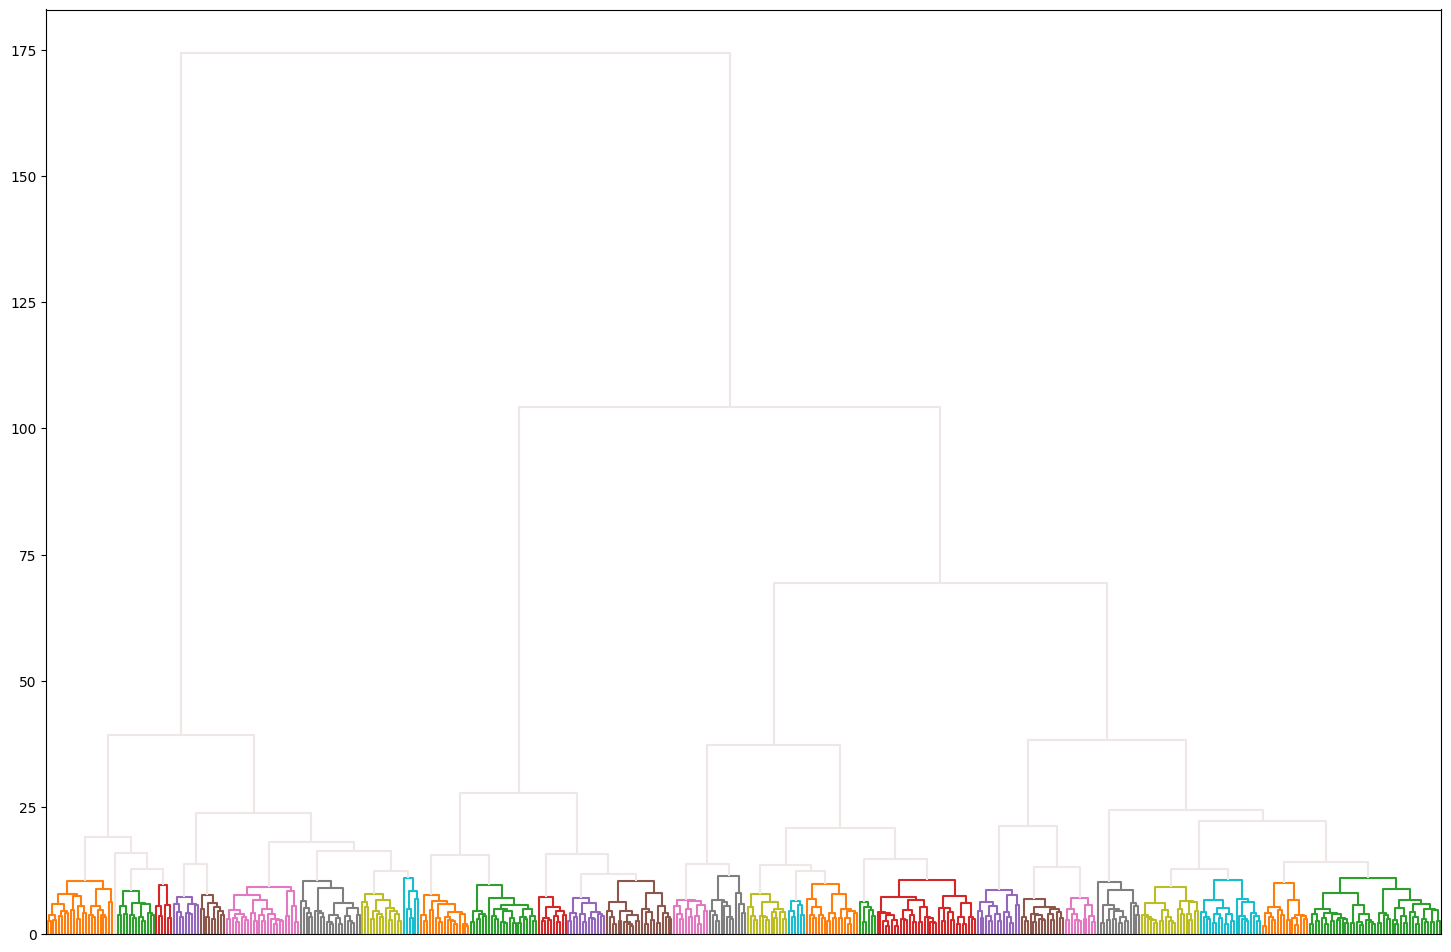

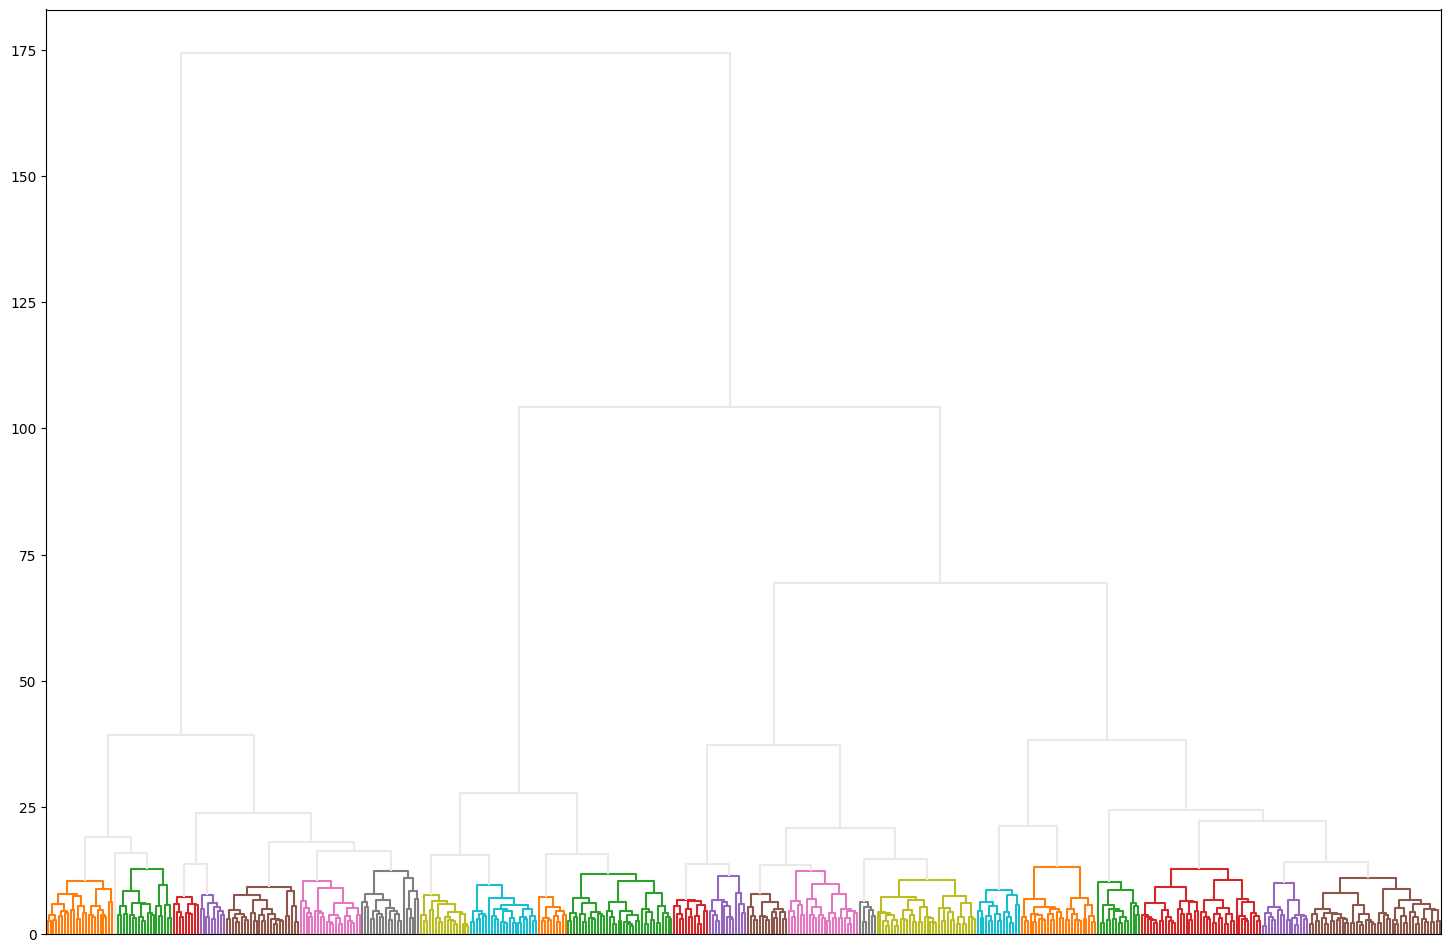

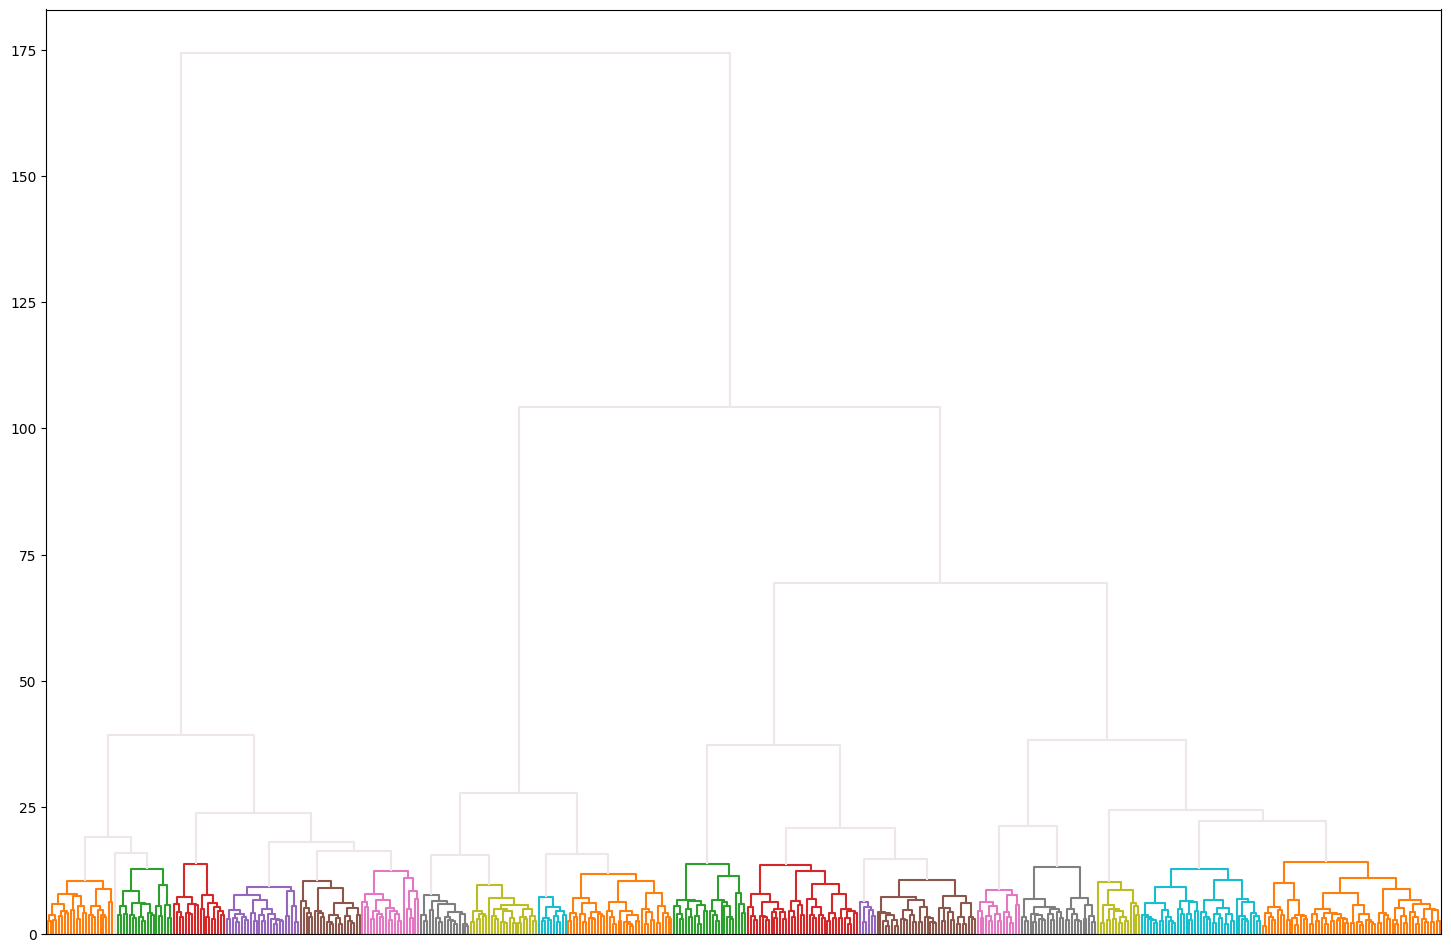

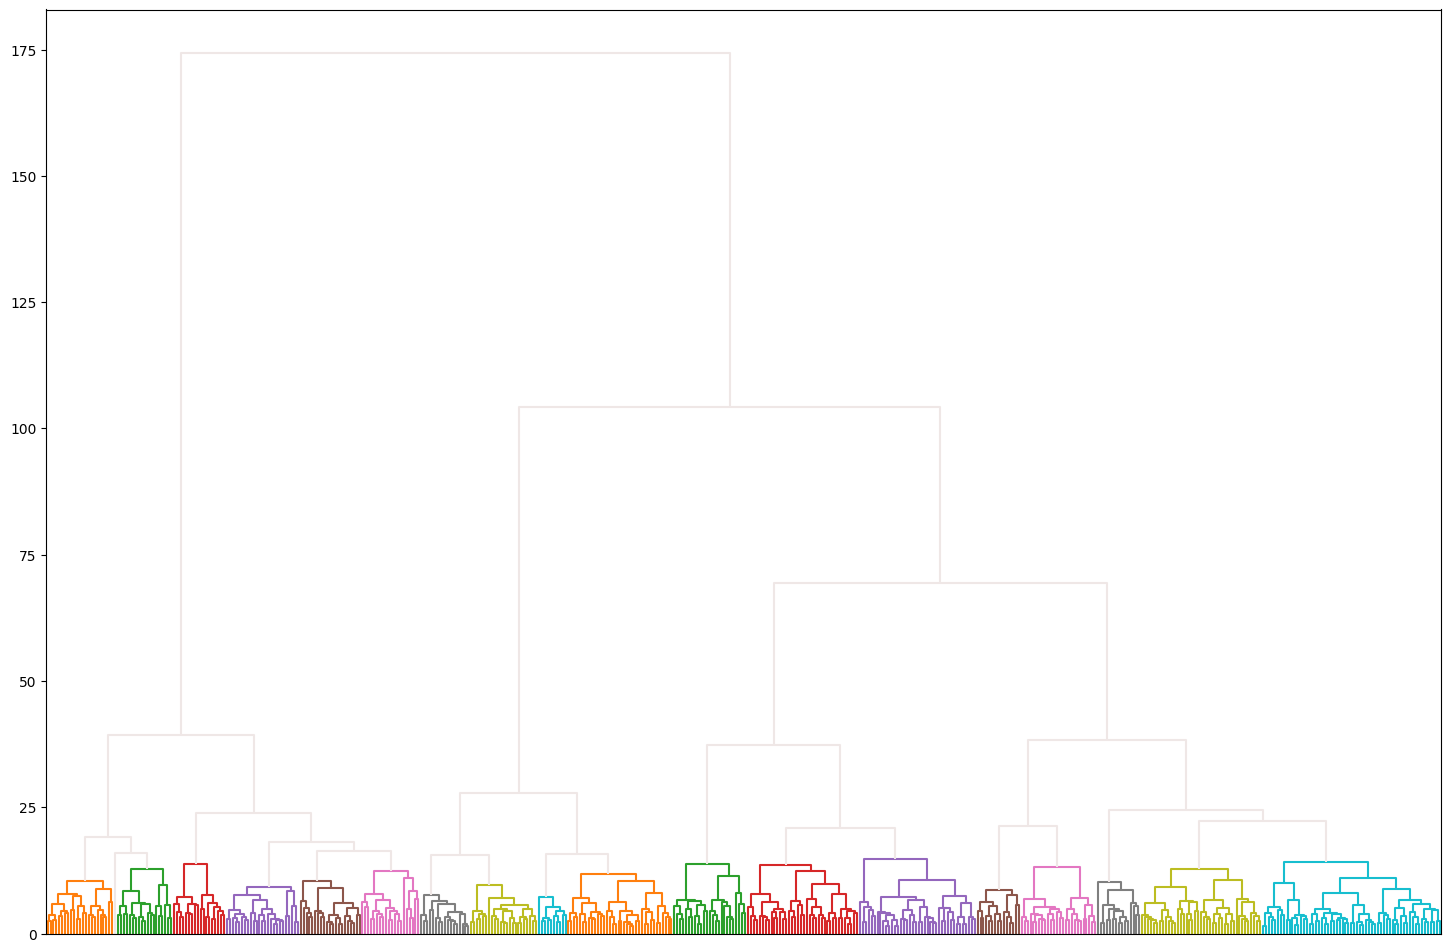

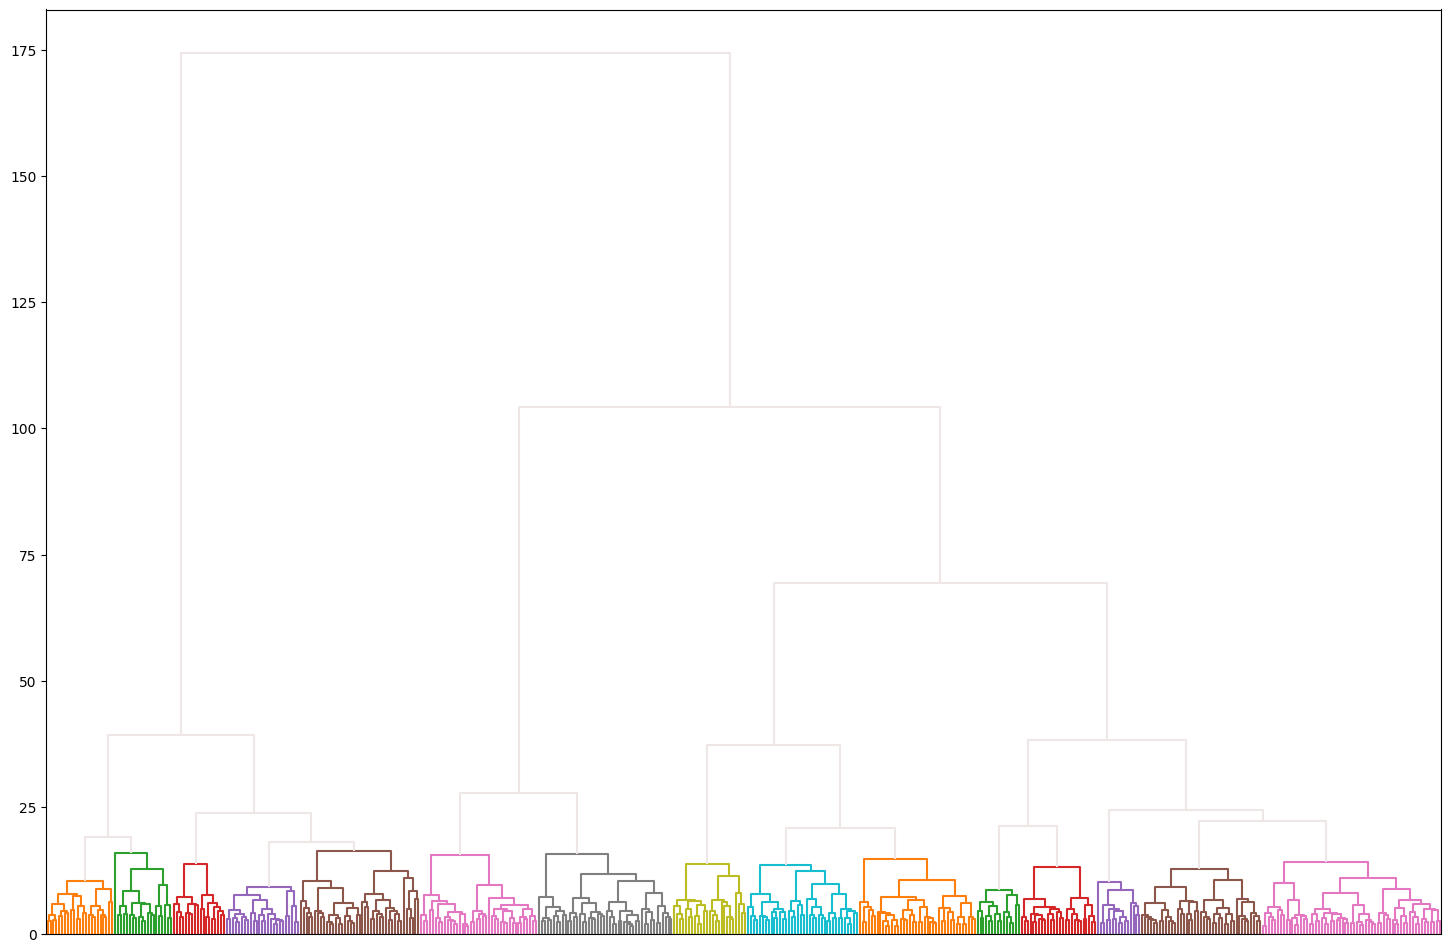

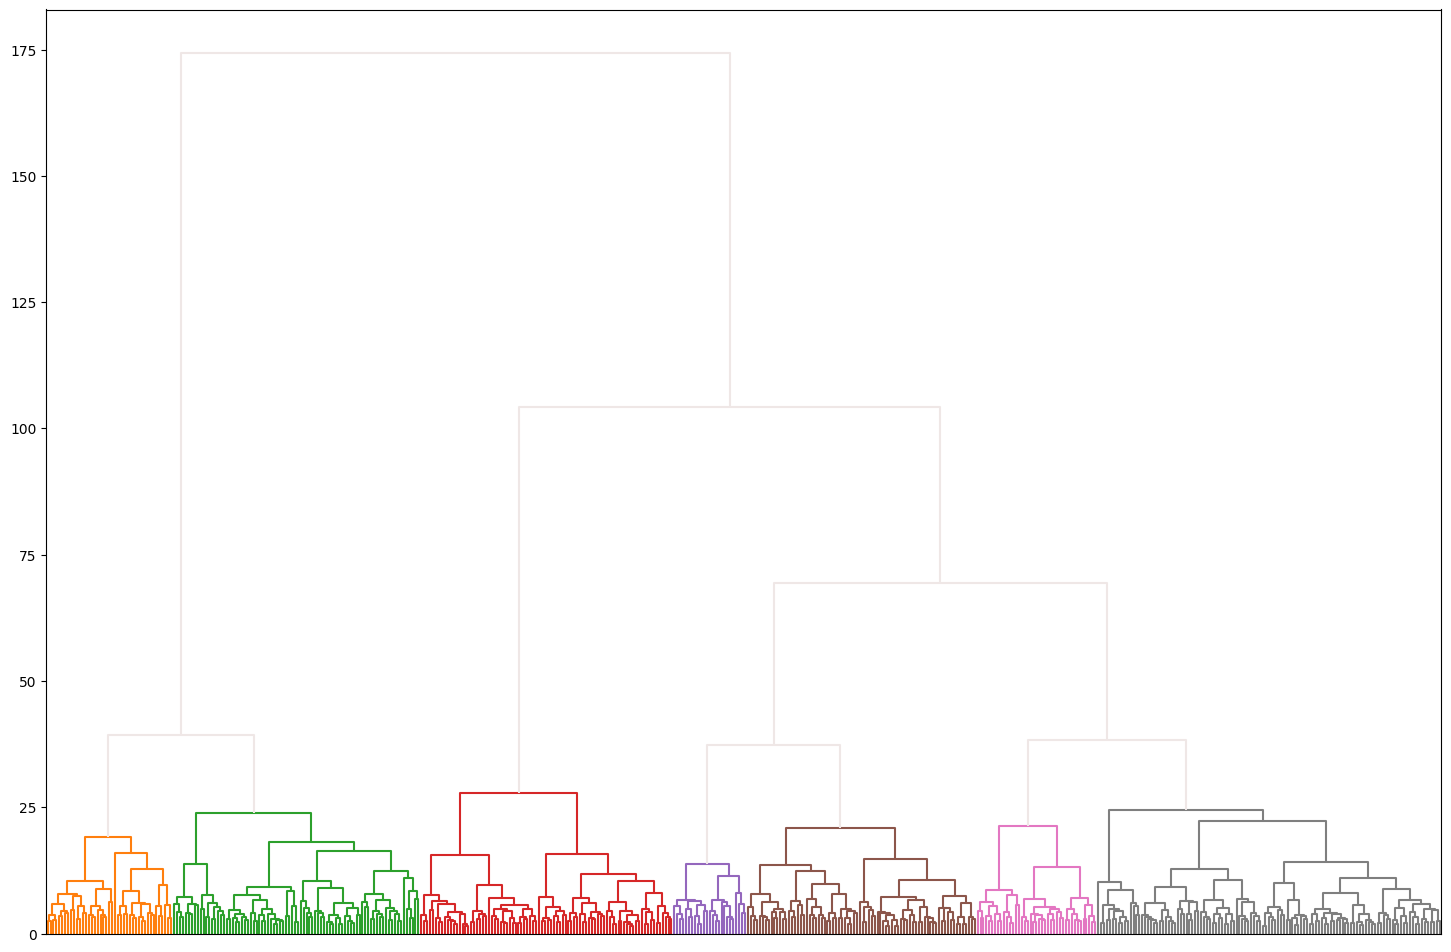

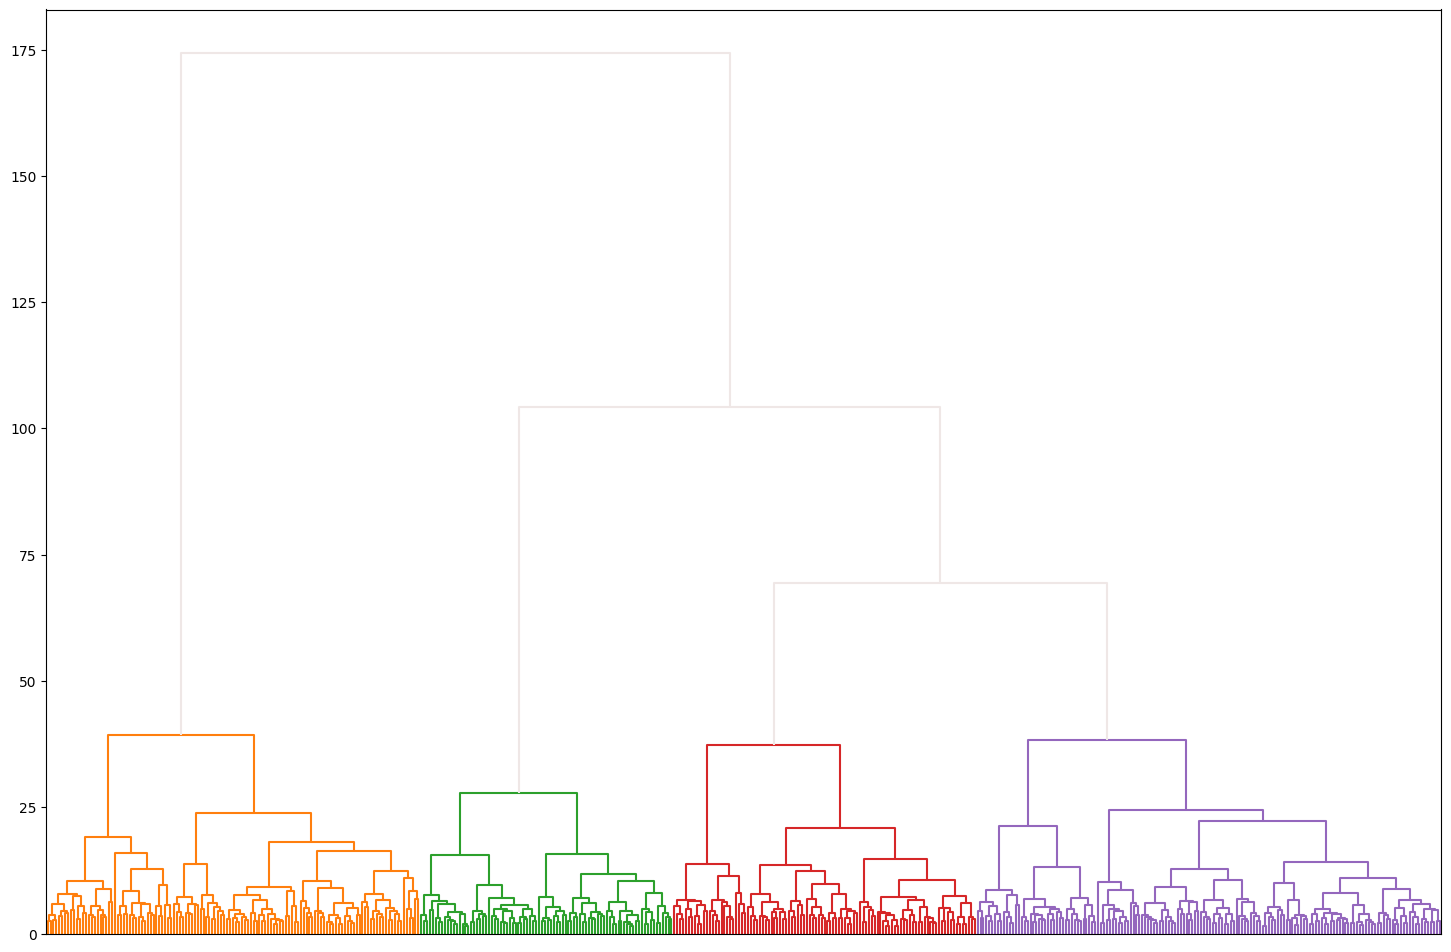

In [66]:
# Проводим кластеризацию
# Подготавливаем директории
if os.path.isdir('Dendrograms'):
    shutil.rmtree('Dendrograms') 
if os.path.isdir('Clasters'):
    shutil.rmtree('Clasters') 
os.mkdir('Dendrograms')
os.mkdir('Clasters')

for method in methods:
    os.mkdir(f'Dendrograms/{method}')    
    os.mkdir(f'Clasters/{method}')
    linked = linkage(df, method)
    for a in range(4):
      trends = []
      a_last = 0
      coef_trend_last = 0
      for coef in range(1, 100 * trend_step, 1):
        coef_trend = coef / trend_step
        for a in range(len(linked)-3):
          if(check_criteria(linked[a][2],linked[a+1][2],linked[a+2][2],linked[a+3][2], coef_trend, a + 3, criteria) > 0):
            threshold = linked[a][2]
            break
        if(a != a_last):
              trends.append([coef_trend_last, coef, a_last, threshold])
              a_last = a
              coef_trend_last = coef_trend
                
      trends.append([coef_trend_last, a+3, linked[-1][2] ])

    for i in range(0,len(trends)):
      cluster_map = {}  
      threshold = linked[-1][2] 
      for a in range(len(linked)-3):
          if(check_criteria(linked[a][2],linked[a+1][2],linked[a+2][2],linked[a+3][2], trends[i][0], a + 3, criteria) > 0):
            threshold = linked[a+3][2]
            break
      fig = plt.gcf()
      fig.set_size_inches(image_width,image_height)        
      dic = dendrogram(linked, color_threshold = threshold, above_threshold_color=above_threshold_color_dendro, no_labels = no_labels_dendro)
      # Save dendrograms
      plt.savefig(f'Dendrograms/{method}/dendro-{i}.jpg', format='jpeg', bbox_inches='tight', edgecolor='black')
      if show_images:
        plt.show()
      clusters = fcluster(linked,threshold, criterion='distance')
      plt.close()
      # Save clasters
      save_clusters(clusters)